Titanic Dataset EDA
===================

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive.

https://www.kaggle.com/jatturat/finding-important-factors-to-survive-titanic

https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

Import Libraries
----------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy
import missingno as msno

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

Import Data
-----------

In [3]:
data_path = Path(Path.cwd() / 'Data')

df_train = pd.read_csv(data_path / 'train.csv')
df_test = pd.read_csv(data_path / 'test.csv')
df_gender_sub = pd.read_csv(data_path / 'gender_submission.csv')

list_of_df = [df_train, df_test]
list_of_df_names = ["Train", "Test"]

In [4]:
X_train = df_train.drop('Survived', axis='columns')
X_test = df_test
y_train = df_train.loc[:,'Survived']

In [5]:
df_train.shape

(891, 12)

In [6]:
df_test.shape

(418, 11)

Investigate Attributes of Datasets
----------------------------------

### Shape
Print out the shape of each dataset

In [7]:
for i in range(2):
    print("The " + list_of_df_names[i] + " dataset has a shape of: ", list_of_df[i].shape)

The Train dataset has a shape of:  (891, 12)
The Test dataset has a shape of:  (418, 11)


The rest of this EDA will focus on the Train dataset to simulate real life situations.

### Head
Examine what each dataset looks like.

In [8]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [9]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The test dataset is missing the `Survived` flag.

### Null Values
Examine the number of null values in the train/test datasets

In [10]:
print("Train")
print(20*'-')
print(df_train.isnull().sum())

Train
--------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Heatmap of Null values in train dataset.

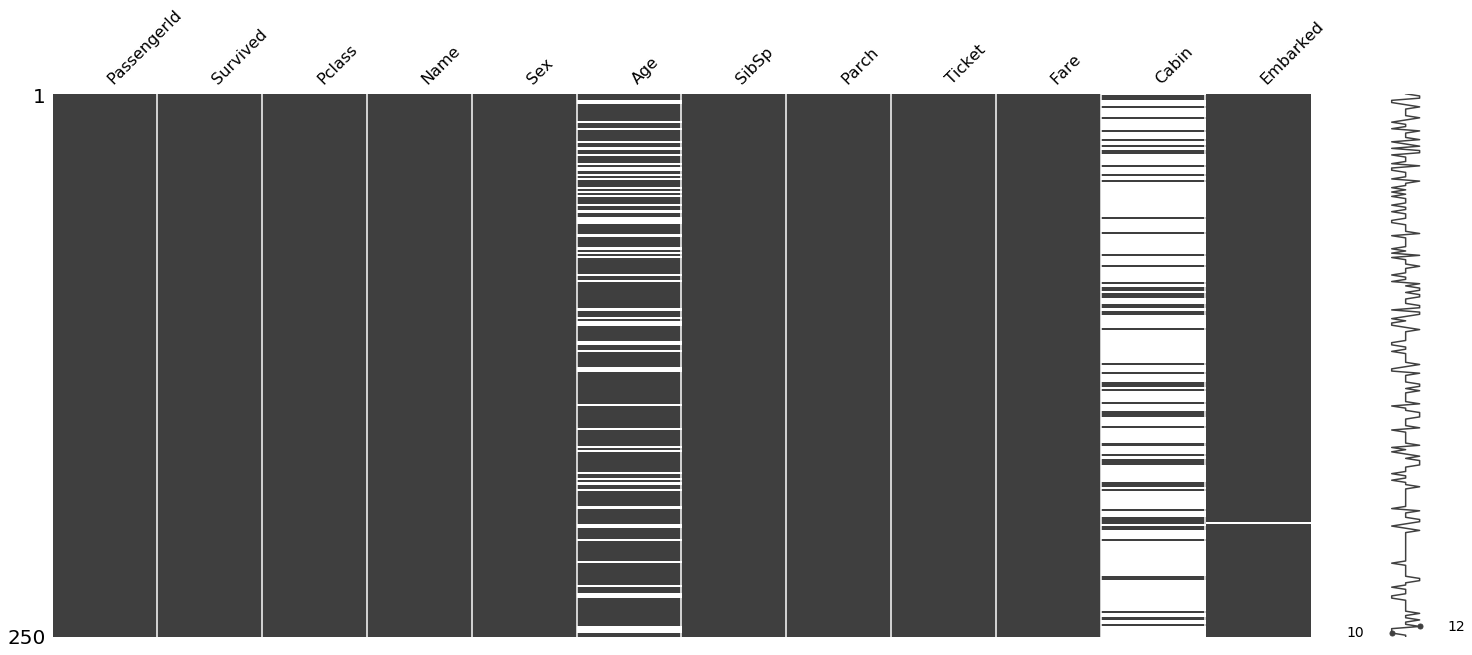

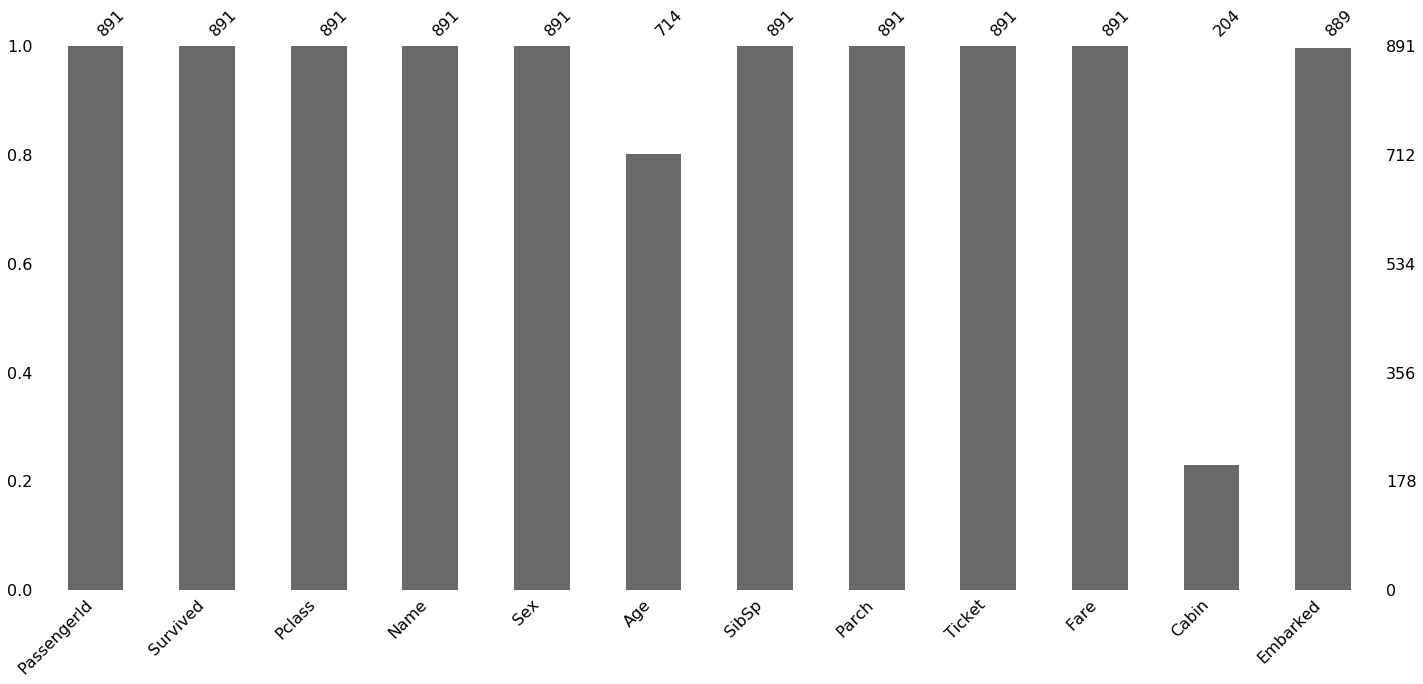

In [11]:
msno.matrix(df_train.sample(250))
msno.bar(df_train)

Examine what the submitted file should look like:

In [12]:
df_gender_sub.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


### Info
Examine the info for the training dataset including datatype, number of entries, null/not-null

In [13]:
print("Train")
print('-'*40)
print(df_train.info())

Train
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


Visualisation Functions
-----------------------

In [14]:
# Continuous Data Plot
def cont_plot(df, feature_name, target_name, palettemap, hue_order, feature_scale): 
    df['Counts'] = "" # A trick to skip using an axis (either x or y) on splitting violinplot
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    sns.distplot(df[feature_name], ax=axis0)
    axis0.set_xlim(left=0)
    sns.violinplot(x=feature_name, y="Counts", hue=target_name, hue_order=hue_order, data=df,
                   palette=palettemap, split=True, orient='h', ax=axis1)
    axis1.set_xlim(left=0)
    axis1.set_xticks(feature_scale)
    plt.show()
    # WARNING: This will leave Counts column in dataset if you continues to use this dataset

# Categorical/Ordinal Data Plot
def cat_plot(df, feature_name, target_name, palettemap): 
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.show()

    
survival_palette = {0: "red", 1: "green"} # Color map for visualization

## Initial Visualisations and Analysis of the Training Data

### Passenger Class

In [15]:
df_train[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


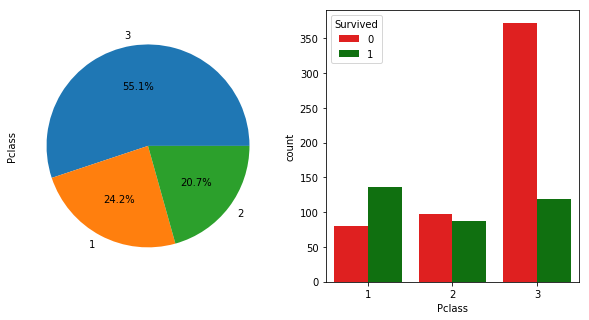

In [16]:
cat_plot(df_train, 'Pclass','Survived', survival_palette)

Pclass represents the class of ticket held by each passenger on the Titanic. People who have first class tickets are represented by, Pclass = 1. People in second class, Pclass = 2 and people in third class, Pclass = 3. Approximately a quarter of passengers are in Pclass1. Pclass1 is the only class which has more survivors. 20% of passengers are in Pclass2 wich has a slightly worse than 50% survival rate. 55% of passengers are in Pclass3, and approximatly 1/5 people from Pclass3 survived.

The Pclass of a person matters for that person to survive or not, therefore this feature is important.

### Sex

In [17]:
df_train[['Sex', 'Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


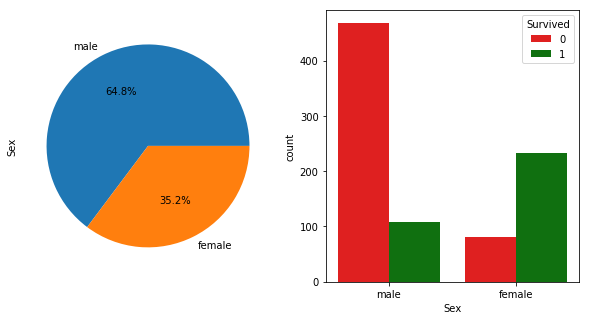

In [18]:
cat_plot(df_train, 'Sex','Survived', survival_palette)

The majority of passengers on the Titanic were male, 65%. A majority of females survived and a majority of males did not.
The sex of a person matters for whether that person survived or not, therfore this feature is important.

### Age

C:\Users\WilliamHoltam\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


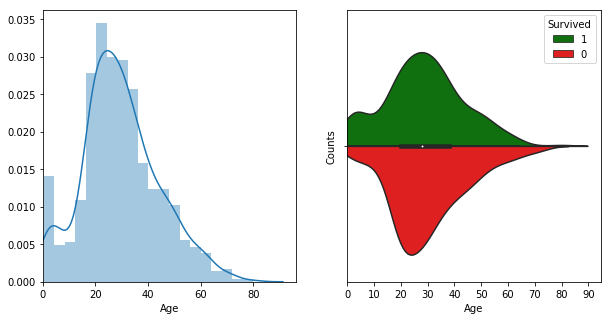

In [19]:
age_set_nonan = df_train[(['Age','Survived'])].copy().dropna(axis=0)
cont_plot(age_set_nonan, 'Age', 'Survived', survival_palette, [1, 0], range(0,100,10))

There were more survivors than fatalities among passangers aged <15. There were fewer survivors than fatalities among passangers between the ages of 15 and 35. Among passengers aged >35 and <60 the numbers of survivors and fatalities is equal again. There are few survivors aged >60. These differences could make it suitable to bin the ages.

In [20]:
df_train[['SibSp', 'Survived']].groupby('SibSp', as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


### Number of Siblings and Spouses

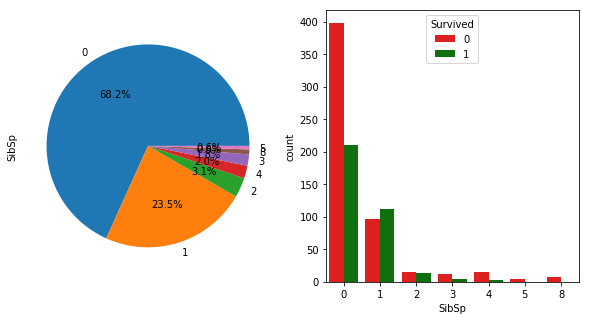

In [21]:
cat_plot(df_train, 'SibSp','Survived', survival_palette)

SibSp represents the number of siblings and spouses a person has.

Only people with 1 sibling or spouse has a >50% chance of survival.

In [22]:
df_train[['Parch', 'Survived']].groupby('Parch', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Number of Parents and Children

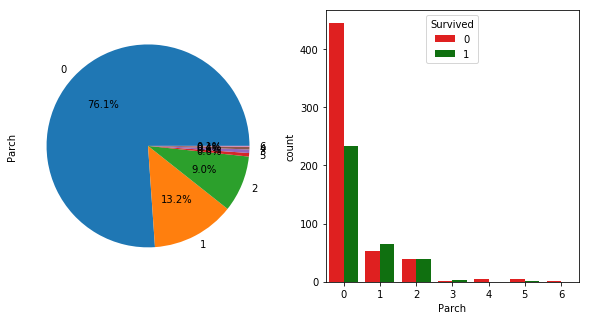

In [23]:
cat_plot(df_train, 'Parch','Survived', survival_palette)

Similar to SibSp, people with few numbers parents/children on board had the best survivability.

Because SibSp and Parch have similar meaning meaning, "Family". If I combine these 2 features together, maybe I could see more differences in each classes of these features.

### Fare

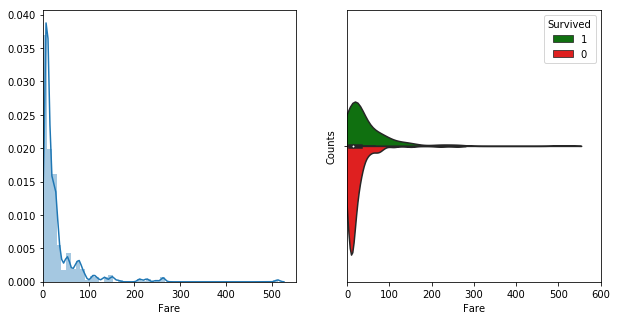

In [24]:
fare_set_nonan = df_train[(['Fare','Survived'])].copy().dropna(axis=0)
cont_plot(fare_set_nonan, 'Fare', 'Survived', survival_palette, [1, 0], range(0,601,100))

On average individuals who paid <£50 for their ticket died and individuals who paid >£50 survived. To get a more granular idea of what's going on I will focus on the lower fares which were purchased by the majority of people.

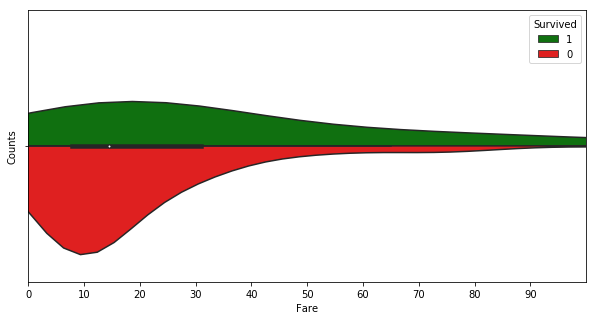

In [25]:
fare_set_mod = df_train[['Fare','Survived']].copy()
fare_set_mod['Counts'] = "" 
fig, axis = plt.subplots(1,1,figsize=(10,5))
sns.violinplot(x='Fare', y="Counts", hue='Survived', hue_order=[1, 0], data=fare_set_mod,
               palette=survival_palette, split=True, orient='h', ax=axis)
axis.set_xticks(range(0,100,10))
axis.set_xlim(0,100)
plt.show()

The threshold at which the number of people who survived > number of people who died is £30

### Embarked Location

In [26]:
df_train[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


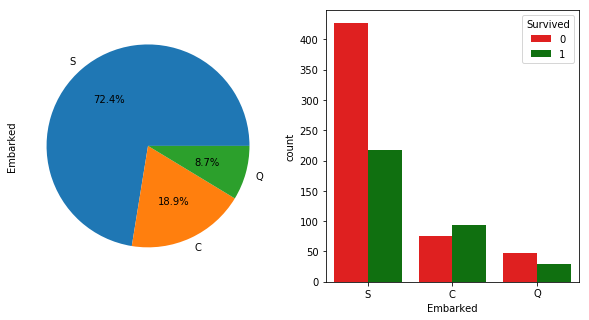

In [27]:
cat_plot(df_train, 'Embarked','Survived', survival_palette)

### Ticket

In [28]:
df_train.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

There is nothing useful here so I will not use the ticket number in the model.

### Cabin

In [29]:
df_train.Cabin.head(20)

0      NaN
1      C85
2      NaN
3     C123
4      NaN
5      NaN
6      E46
7      NaN
8      NaN
9      NaN
10      G6
11    C103
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
Name: Cabin, dtype: object

The majority of cabins are NaN. I could group these into another cagegory: "Unknown Cabin".
The I can extract information about the known cabins by taking the first letter from cabin code and using that as a categorical feature.

In [30]:
df_train.shape

(891, 12)

In [31]:
df_test.shape

(418, 11)

Feature Engineering
-------------------

### Title

In [32]:
titles = set()
for name in df_train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
    
print(titles)

{'Don', 'Rev', 'Dr', 'Major', 'Sir', 'Mlle', 'the Countess', 'Capt', 'Col', 'Jonkheer', 'Master', 'Mr', 'Mrs', 'Mme', 'Ms', 'Lady', 'Miss'}


In [33]:
class HonorificExtractor(BaseEstimator, TransformerMixin):
    
    """
    Custom SK-learn transformer.
    Extracts honorifics from a string type column and groups them further into:
    Officer, Royalty, Mr, Mrs, Miss, Master.
    NaN is assumed to be Mr.
    """
    
    def __init__(self, column):
        self.column = column
    
    title_dictionary = {
        "Mr": "Mr",
        "Miss": "Miss",
        "Mrs": "Mrs",
        "Master": "Master",
        "Dr": "Scholar",
        "Rev": "Religious",
        "Col": "Officer",
        "Major": "Officer",
        "Mlle": "Miss",
        "Don": "Noble",
        "Dona": "Dona",
        "the Countess": "Noble",
        "Ms": "Mrs",
        "Mme": "Mrs",
        "Capt": "Noble",
        "Lady": "Noble",
        "Sir": "Noble",
        "Jonkheer": "Noble"
    }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.X_temp = X[self.column].map(lambda name:name.split(',')[1].split('.')[0].strip())
        X['Title'] = self.X_temp.map(self.title_dictionary)
        return X

This class has been built as an sk-learn transformer so that it can be applied to the train and test datasets in an sklearn pipeline.

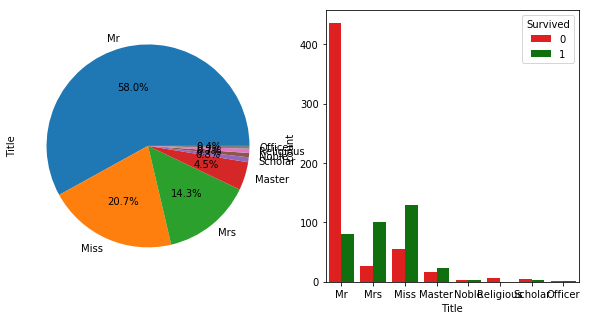

In [34]:
test_title = HonorificExtractor(column='Name').fit_transform(df_train)
cat_plot(test_title, 'Title','Survived', survival_palette)

This engineered feature provides value as the survival of an individual depends strongly on their title.

In [35]:
df_train.shape

(891, 13)

In [36]:
df_test.shape

(418, 11)

### Impute Ages

In [37]:
print("There are:", df_train.Age.isnull().sum(), "missing age values")

There are: 177 missing age values


In [38]:
grouped_train = df_train.groupby(['Sex','Pclass', 'Embarked', 'Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Embarked', 'Title', 'Age', ]]
grouped_median_train.head()

,Sex,Pclass,Embarked,Title,Age
0,female,1,C,Miss,30.5
1,female,1,C,Mrs,44.0
2,female,1,C,Noble,48.0
3,female,1,Q,Miss,33.0
4,female,1,S,Miss,23.0


This dataframe will help us impute missing age values based on different criteria.

In [39]:
class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        grouped_train = X.groupby(['Sex','Pclass', 'Embarked', 'Title'])
        self.grouped_median_train = grouped_train.median()
        self.grouped_median_train = self.grouped_median_train.reset_index()[['Sex', 'Pclass', 'Embarked', 'Title', 'Age']]
        self.median_age = X.Age.median()
        return self

    def fill_age(self, row):
        condition = (
            (self.grouped_median_train['Sex'] == row['Sex']) & 
            (self.grouped_median_train['Pclass'] == row['Pclass']) &
            (self.grouped_median_train['Title'] == row['Title']) &
            (self.grouped_median_train['Embarked'] == row['Embarked'])
        )
        
        if any(condition) == True:
            return self.grouped_median_train[condition]['Age'].values[0]
        else:
            return self.median_age

    def transform(self, X):
        # a function that fills the missing values of the Age variable
        X['Age'] = X.apply(lambda row: self.fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
        return X

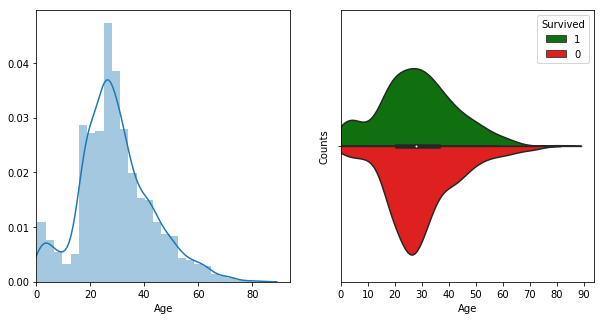

In [40]:
test_age = AgeImputer().fit_transform(df_train)
age_set_nonan = test_age[(['Age','Survived'])].copy().dropna(axis=0)
cont_plot(age_set_nonan, 'Age', 'Survived', survival_palette, [1, 0], range(0,100,10))

### Age Binning

In [41]:
class AgeBinner(BaseEstimator, TransformerMixin):
    
    """
    Bins ages into categorical bins
    """
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 30), (30, 60), (60,1000)])
        X['CategoricalAge'] = pd.cut(X['Age'], bins=bins)
        return X

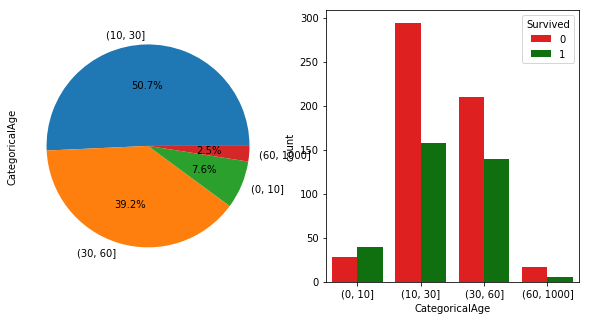

In [42]:
test_age_bin = AgeBinner().fit_transform(df_train)
cat_plot(test_age_bin, 'CategoricalAge','Survived', survival_palette)

### Fare Binning

In [43]:
class FareBinning(BaseEstimator, TransformerMixin):
    
    """
    Bins ages into categorical bins
    """
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        X.Fare.fillna(X.Fare.mean(), inplace=True)
        X['CategoricalFare'] = pd.cut(X['Fare'], 10)
        return X

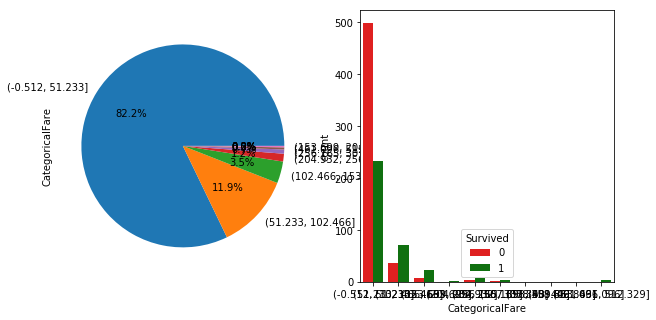

In [44]:
test_fare_bin = FareBinning().fit_transform(df_train)
cat_plot(test_fare_bin, 'CategoricalFare','Survived', survival_palette)

### Cabin

In [45]:
class HasCabin(BaseEstimator, TransformerMixin):
    
    """
    Groups the cabins into categories based on the first letter in the cabin code.
    If a field is null it is filled with "No Assigned Cabin"
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.Cabin = X.Cabin.str[0]
        X.Cabin = X.Cabin.fillna("U")
        return X

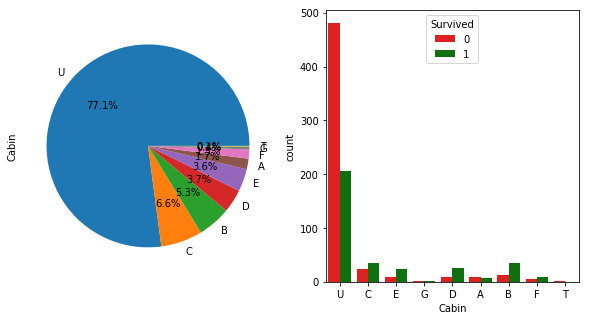

In [46]:
temp = df_train
test_cabin = HasCabin().fit_transform(temp)
cat_plot(test_cabin, 'Cabin','Survived', survival_palette)

### Family Size

In [47]:
class FamilyCreator(BaseEstimator, TransformerMixin):
    
    """
    Creates a new feature called FamilySize
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        return X

C:\Users\WilliamHoltam\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


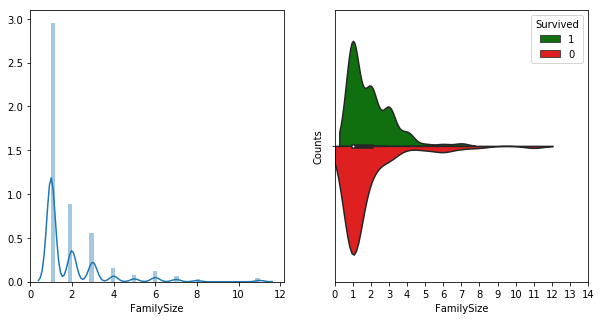

In [48]:
test_family = FamilyCreator().fit_transform(df_train)
family_set_nonan = test_family[(['FamilySize','Survived'])].copy().dropna(axis=0)
cont_plot(family_set_nonan, 'FamilySize', 'Survived', survival_palette, [1, 0], range(0,15,1))

In [49]:
class FamilyBinner(BaseEstimator, TransformerMixin):
    
    """
    Creates a new feature called FamilyBin
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Family'] = ''
        X.loc[X['FamilySize'] == 0, 'Family'] = 'alone'
        X.loc[(X['FamilySize'] > 0) & (X['FamilySize'] <= 3), 'Family'] = 'small'
        X.loc[(X['FamilySize'] > 3) & (X['FamilySize'] <= 6), 'Family'] = 'medium'
        X.loc[X['FamilySize'] > 6, 'Family'] = 'large'
#         X = X.drop('FamilySize', axis='columns')
        return X

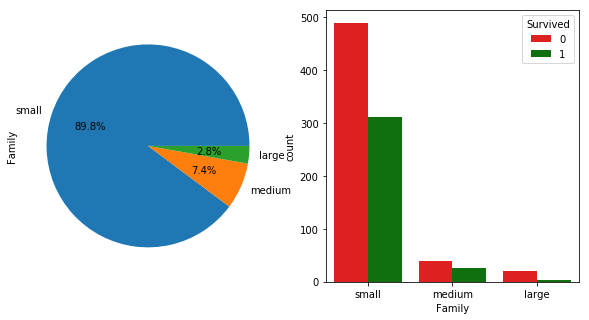

In [50]:
test_family_bin = FamilyBinner().fit_transform(df_train)
cat_plot(test_family_bin, 'Family','Survived', survival_palette)

### Alone Flag

In [51]:
class IsAlone(BaseEstimator, TransformerMixin):
    
    """
    Engineers new feature to determine whether individual is alone on the Titanic.
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['IsAlone'] = 0
        X.loc[X['FamilySize'] == 1, 'IsAlone'] = 1
        return X

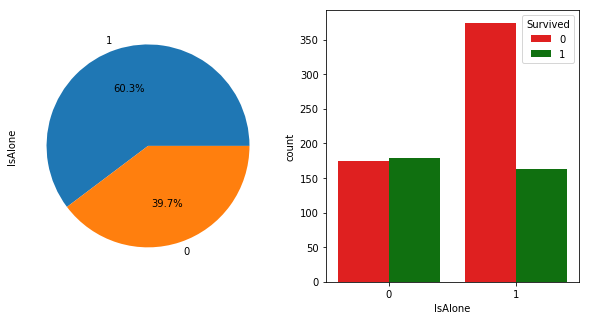

In [52]:
test_alone = IsAlone().fit_transform(df_train)
cat_plot(test_alone, 'IsAlone','Survived', survival_palette)

### Ticket Binning

In [53]:
def CleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

tickets = set()
for t in df_train['Ticket']:
    tickets.add(CleanTicket(t))
    
print("There are:", len(tickets), "tickets.")
print(tickets)

There are: 31 tickets.
{'WEP', 'A4', 'SOTONOQ', 'SWPP', 'XXX', 'SCA4', 'CASOTON', 'CA', 'FC', 'SCPARIS', 'FCC', 'WC', 'SC', 'STONO', 'STONO2', 'SCAH', 'C', 'SOPP', 'SCOW', 'PC', 'SOTONO2', 'LINE', 'SP', 'A5', 'Fa', 'AS', 'SCParis', 'PP', 'SOC', 'SOP', 'PPP'}


In [54]:
class TicketProcesser(BaseEstimator, TransformerMixin):
    
    """

    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Ticket'] = X['Ticket'].map(CleanTicket)
        return X

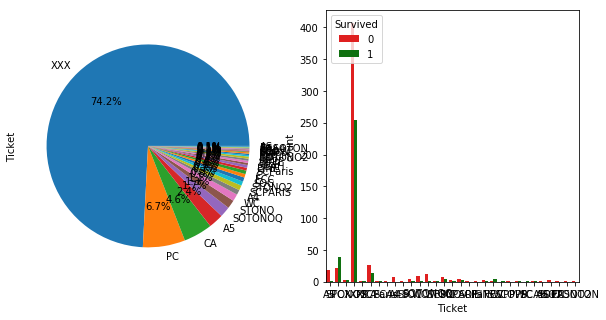

In [55]:
test_ticket = TicketProcesser().fit_transform(df_train)
cat_plot(test_ticket, 'Ticket','Survived', survival_palette)

### Sparse Array --> Dense

In [56]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    
    """
    Custom SK-learn transformer.
    Returns a dense array.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if scipy.sparse.issparse(X) == True:
            X = X.todense()
        return X

In [57]:
class CorrelationPlot(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        print(X.columns)
        
        colormap = plt.cm.viridis
        sns.heatmap(
            X_train.corr(),
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)
        plt.show()
        return X

In [58]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    """
    Custom SK-learn transformer.
    Returns a dense array.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
#         X = X.drop([
#             "Fare",
#             'Age',
#             'SibSp',
#             'Parch',
#             'FamilySize',
#             'Cabin',
# #           'IsAlone'
#         ], axis="columns")
        return X

In [59]:
PrePreprocessingPipe = Pipeline(
    steps=[
        ("he", HonorificExtractor(column="Name")),
        ("fc", FamilyCreator()),
        ("famb", FamilyBinner()),
        ("ia", IsAlone()),
        ("ai", AgeImputer()),
        ("ab", AgeBinner()),
        ("farb", FareBinning()),
        ("cg", HasCabin()),
#         ("cp", CorrelationPlot()),
        ("fd", FeatureDropper())
    ]
)

In [60]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title',
       'CategoricalAge', 'CategoricalFare', 'FamilySize', 'Family', 'IsAlone'],
      dtype='object')

In [61]:
numeric_features = ['Fare', 'Age', 'SibSp', 'Parch', 'FamilySize']
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [62]:
categorical_features = ['Embarked', 'Sex', 'Pclass', 'CategoricalAge', 'CategoricalFare', 'Title', 'Family', 'Ticket', 'Name', 'IsAlone', 'Cabin', 'FamilySize']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [63]:
PreprocessingPipeline = Pipeline(
    steps=[
        ("pp", PrePreprocessingPipe),
        ("ct", ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        ))
    ]
)

In [64]:
RFC = RandomForestClassifier(n_estimators=50, max_features='sqrt')
Model = Pipeline(
    steps=[
        ('pp', PreprocessingPipeline),
        ('to_dense', DenseTransformer()),
        ('classifier', RFC)
    ]
)
Model = Model.fit(X_train, y_train)
features = pd.DataFrame()
features['importance'] = Model.get_params(deep=True)['classifier'].feature_importances_
print(len(features))

1627


In [65]:
important_features_index = np.transpose(features.nlargest(n=100, columns=['importance']).index)

In [66]:
class FeatureImportance(BaseEstimator, TransformerMixin):
    
    """

    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X[:,important_features_index]
        return X

In [67]:
model = Pipeline(
    steps=[
        ('pp', PreprocessingPipeline),
        ('to_dense', DenseTransformer()),
        ('fi_selector', SelectFromModel(RFC, prefit=True))
    ]
)
train_reduced = model.transform(X_train)
print(train_reduced.shape)
print(X_train.shape, X_test.shape)

(891, 254)
(891, 17) (418, 11)


In [68]:
test_reduced = model.transform(X_test)
print(test_reduced.shape)

(418, 254)


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize', 'Family',
       'IsAlone', 'CategoricalAge', 'CategoricalFare'],
      dtype='object')
PassengerId           int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
Title                object
FamilySize            int64
Family               object
IsAlone               int64
CategoricalAge     category
CategoricalFare    category
dtype: object


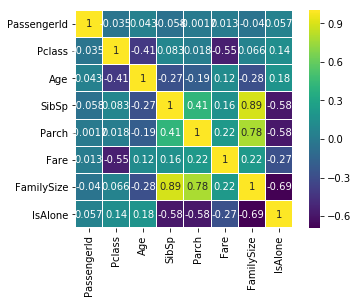

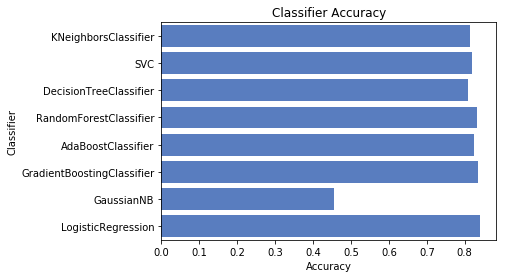

                   Classifier  Accuracy
0        KNeighborsClassifier  0.813433
0                         SVC  0.819403
0      DecisionTreeClassifier  0.807463
0      RandomForestClassifier  0.832090
0          AdaBoostClassifier  0.823134
0  GradientBoostingClassifier  0.835075
0                  GaussianNB  0.454478
0          LogisticRegression  0.841045


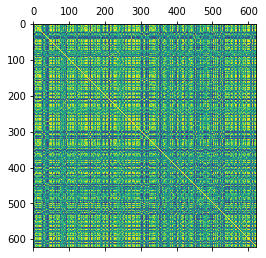

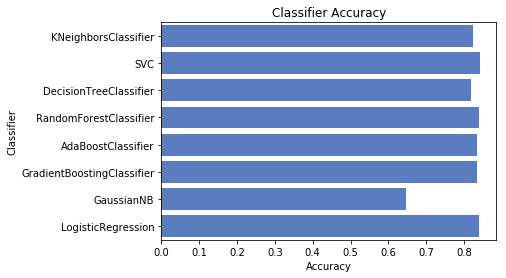

                   Classifier  Accuracy
0        KNeighborsClassifier  0.825000
0                         SVC  0.843284
0      DecisionTreeClassifier  0.819776
0      RandomForestClassifier  0.839179
0          AdaBoostClassifier  0.834701
0  GradientBoostingClassifier  0.834701
0                  GaussianNB  0.647015
0          LogisticRegression  0.840672


In [69]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True, gamma='scale'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs')
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=2)

acc_dict = {}

for train_index, test_index in sss.split(X_train.values, y_train.values): 
    Xtrain, Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        Model = Pipeline(
            steps=[
                ('pp', PreprocessingPipeline),
                ('to_dense', DenseTransformer()),
                ('classifier', clf)
            ]
        )
        Model.fit(Xtrain, ytrain)
        train_predictions = Model.predict(Xtest)
        acc = accuracy_score(ytest, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

print(Xtrain.columns)
print(Xtrain.dtypes)

colormap = plt.cm.viridis
sns.heatmap(X_train.corr(),
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)
plt.show()

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.show()

print(log)

acc_dict = {}

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=2)

for train_index, test_index in sss.split(X_train.values, y_train.values): 
    Xtrain, Xtest = train_reduced[train_index], train_reduced[test_index]
    ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        Model = Pipeline(
            steps=[
                ('classifier', clf)
            ]
        )
        Model.fit(Xtrain, ytrain)
        train_predictions = Model.predict(Xtest)
        acc = accuracy_score(ytest, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)
    
plt.matshow(np.corrcoef(Xtrain))
plt.show()

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.show()

print(log)

Feature Importances have improved the performance of the decision tree based classifiers.

In [112]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
        'C': [1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'shrinking': [True, False]
#         'random_state': 10,
#         'probability': True
    }

    svc = SVC(probability=True, gamma='scale')
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(svc,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=10
                              )

    grid_search.fit(train_reduced, y_train.values)
    model = grid_search
    parameters = grid_search.best_params_
    
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'C': 6, 'gamma': 2.0, 'kernel': 'linear', 'probability': True, 'shrinking': True}
    
    model = SVC(**parameters)
    model.fit(train_reduced, y_train)
    y_predict = model.predict(test_reduced)
    df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
    df_results.to_csv("submission_fi.csv", index=False)

In [127]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
        'max_depth' : [4, 6, 8, 12, 14, 16],
        'n_estimators': [50, 10],
        'max_features': ['sqrt', 'auto', 'log2'],
        'min_samples_split': [2, 3, 10],
        'min_samples_leaf': [1, 3, 10],
        'bootstrap': [True, False]
    }

    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=10,
                               n_jobs=-1
                              )

    grid_search.fit(train_reduced, y_train.values)
    model = grid_search
    parameters = grid_search.best_params_
    
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train_reduced, y_train)

In [128]:
y_predict = model.predict(test_reduced)
df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
df_results.to_csv("submission_RFC.csv", index=False)

RFC is the best performing classifier

In [122]:
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features=None, presort=True, splitter='random')
model.fit(train_reduced, y_train)
y_predict = model.predict(test_reduced)
df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
df_results.to_csv("submission_DTC.csv", index=False)

In [120]:
model = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.12, loss='deviance', n_estimators=110)
model.fit(train_reduced, y_train)
y_predict = model.predict(test_reduced)
df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
df_results.to_csv("submission_GBC.csv", index=False)

In [121]:
model = LogisticRegression(C=30, dual=False, fit_intercept=True, penalty='l2', solver='newton-cg', tol=1e-05, max_iter=300)
model.fit(train_reduced, y_train)
y_predict = model.predict(test_reduced)
df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
df_results.to_csv("submission_LR.csv", index=False)

In [108]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression()
]

parameter_grid = [
    {
        "n_neighbors": [2, 3, 4],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size" : [10, 15, 20],
    },
    {
        "C": [6, 8, 10],
        "kernel": ["linear", "rbf", "poly"],
        "shrinking": [True, False],
        "probability": [True, False],
        "gamma": [2.0, 2.5, 3.0, "scale"]
    },
    {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_features": ["auto", "sqrt", "log2", None],
        "class_weight": ["balanced", None],
        "presort": [True, False]
    },
    {
        "max_depth" : [16, 18, 20],
        "n_estimators": [100, 50, 10],
        "max_features": ["sqrt", "auto", "log2"],
        "min_samples_split": [2, 3],
        "min_samples_leaf": [1, 2],
        "bootstrap": [True, False]
    },
    {
        "n_estimators": [60, 80],
        "algorithm": ["SAMME.R"],
        "learning_rate": [1.2, 1.4]
    },
    {
        "loss": ["deviance", "exponential"],
        "learning_rate": [0.08, 0.1, 0.12],
        "n_estimators": [90, 100, 110],
        "criterion": ["friedman_mse", "mse", "mae"],
    },
    {
        "var_smoothing" : [1e-9, 2e-9]
    },
    {
        "penalty": ["l2"],
        "dual": [False],
        "tol": [1e-5],
        "C": [30, 35, 40],
        "fit_intercept": [True, False],
        "solver": ["newton-cg", "lbfgs", "sag"],
        "max_iter": [200, 400, 1000]
    }
]

run_gs = True

if run_gs:
    for clf in range(len(classifiers)):    
        cross_validation = StratifiedKFold(n_splits=5)
    
        grid_search = GridSearchCV(
            classifiers[clf],
            scoring="accuracy",
            param_grid=parameter_grid[clf],
            cv=cross_validation,
            verbose=1,
            n_jobs=-1
        )
    
        grid_search.fit(train_reduced, y_train.values)
        model = grid_search
        parameters = grid_search.best_params_
        
        print("Classifier: {}".format(classifiers[clf].__class__.__name__))
        print('Best score: {}'.format(grid_search.best_score_))
        print('Best parameters: {}'.format(grid_search.best_params_))
else:
    parameters = {'C': 10, 'kernel': 'linear', 'probability': True, 'shrinking': False, 'gamma': 'scale'}
    
    model = SVC(**parameters)
    model.fit(train_reduced, y_train)
    y_predict = model.predict(test_reduced)
    df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
    df_results.to_csv("submission_fi.csv", index=False)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Classifier: KNeighborsClassifier
Best score: 0.8271604938271605
Best parameters: {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.5min finished


Classifier: SVC
Best score: 0.8417508417508418
Best parameters: {'C': 6, 'gamma': 2.0, 'kernel': 'linear', 'probability': True, 'shrinking': True}
Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Classifier: DecisionTreeClassifier
Best score: 0.8451178451178452
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'presort': True, 'splitter': 'random'}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1020 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   28.1s finished
C:\Users\WilliamHoltam\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Classifier: RandomForestClassifier
Best score: 0.8473625140291807
Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Classifier: AdaBoostClassifier
Best score: 0.8271604938271605
Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.4, 'n_estimators': 60}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.8min finished


Classifier: GradientBoostingClassifier
Best score: 0.8260381593714927
Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.12, 'loss': 'deviance', 'n_estimators': 110}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Classifier: GaussianNB
Best score: 0.6520763187429854
Best parameters: {'var_smoothing': 1e-09}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.5s


Classifier: LogisticRegression
Best score: 0.8439955106621774
Best parameters: {'C': 30, 'dual': False, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1e-05}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   32.6s finished


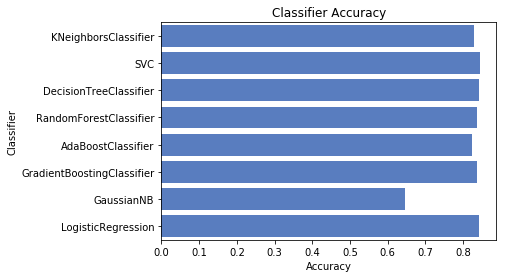

                   Classifier  Accuracy
0        KNeighborsClassifier  0.828731
0                         SVC  0.845522
0      DecisionTreeClassifier  0.842537
0      RandomForestClassifier  0.837687
0          AdaBoostClassifier  0.824254
0  GradientBoostingClassifier  0.837313
0                  GaussianNB  0.647015
0          LogisticRegression  0.841418


In [111]:
params = {'C': 6, 'gamma': 2.0, 'kernel': 'linear', 'probability': True, 'shrinking': True}

classifiers = [
    KNeighborsClassifier(algorithm='brute', leaf_size=10, n_neighbors=3, weights='distance'),
    SVC(**params),  # C=8, gamma=0.25, kernel='linear', probability=True, shrinking=True),
    DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_features=None, presort=True, splitter='random'),
    RandomForestClassifier(bootstrap=True, max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=3, n_estimators=100),
    AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1.4, n_estimators=60),
    GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.12, loss='deviance', n_estimators=110),
    GaussianNB(),
    LogisticRegression(C=30, dual=False, fit_intercept=True, penalty='l2', solver='newton-cg', tol=1e-05, max_iter=200)
]

acc_dict = {}

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=2)

for train_index, test_index in sss.split(X_train.values, y_train.values): 
    Xtrain, Xtest = train_reduced[train_index], train_reduced[test_index]
    ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        Model = Pipeline(
            steps=[
                ('classifier', clf)
            ]
        )
        Model.fit(Xtrain, ytrain)
        train_predictions = Model.predict(Xtest)
        acc = accuracy_score(ytest, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)
    
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.show()

print(log)